<a href="https://colab.research.google.com/github/chiwacych/greenhouse-ml/blob/main/crop_diseases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wandb

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from google.colab import drive

In [ ]:
import wandb
wandb.login()  # Will prompt you to paste an API key if not already logged in

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: chiwa-vw (chiwa-vw-personal) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
# ✅ Mount Google Drive (to save model)
drive.mount('/content/drive')
SAVE_PATH = "/content/drive/MyDrive/trained_models/"  # ✅ Update this if needed
os.makedirs(SAVE_PATH, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Device setup (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# ✅ Select Device: GPU (if available), otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# ✅ Configure batch sizes for GPU (T4)
CROP_CONFIG = {
    'Tomato': {'path': 'Tomato', 'batch_size': 64},
    'Potato': {'path': 'Potato', 'batch_size': 48},  # Reduce batch size to prevent OOM
    'Maize': {'path': 'Maize', 'batch_size': 64},
    'Bean': {'path': 'Bean', 'batch_size': 48},
    'Cashew': {'path': 'Cashew', 'batch_size': 64},
    'Cassava': {'path': 'Cassava', 'batch_size': 64}
}

# ✅ Dataset path (Update if needed)
DATASET_PATH = '/content/drive/MyDrive/Dataset_aug'

In [ ]:
# Data pipeline: Dataset and transformations

class CropDataset:
    def __init__(self, root_path, crop_type, img_size=224, batch_size=64):
        self.root = os.path.join(root_path, crop_type)
        self.train_path = os.path.join(self.root, 'train_set')
        self.test_path = os.path.join(self.root, 'test_set')

        # ✅ Image Preprocessing
        self.train_transform = transforms.Compose([
            transforms.RandomResizedCrop(img_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        self.batch_size = batch_size

    def get_loaders(self):
        train_set = datasets.ImageFolder(self.train_path, transform=self.train_transform)
        test_set = datasets.ImageFolder(self.test_path, transform=self.train_transform)

        train_loader = DataLoader(train_set, batch_size=self.batch_size, shuffle=True, num_workers=4, pin_memory=True)
        test_loader = DataLoader(test_set, batch_size=self.batch_size, shuffle=False, num_workers=4, pin_memory=True)

        return train_loader, test_loader, train_set.classes

In [ ]:
def create_model(num_classes):
    """Creates an EfficientNet model optimized for GPU (EfficientNet B0 for speed)"""
    model = models.efficientnet_b0(pretrained=True)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    return model.to(device)

In [ ]:
'''# Training class with saving model functionality
class CropTrainer:
    def __init__(self, model, train_loader, test_loader, classes, save_name):
        self.model = model
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.classes = classes
        self.save_name = save_name  # Model file name

        # ✅ Optimizer & Loss
        self.optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.01)
        self.criterion = nn.CrossEntropyLoss()

    def train_epoch(self, epoch):
        self.model.train()
        running_loss = 0.0

        for inputs, labels in tqdm(self.train_loader, desc=f"Epoch {epoch+1}"):
            inputs, labels = inputs.to(device), labels.to(device)

            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)

            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()

        return running_loss / len(self.train_loader)

    def train(self, epochs=15):
        for epoch in range(epochs):
            loss = self.train_epoch(epoch)
            print(f"[Epoch {epoch+1}] Loss: {loss:.4f}")

            if (epoch+1) % 5 == 0:  # ✅ Save every 5 epochs
                self.save_checkpoint(epoch)

    def save_checkpoint(self, epoch):
        """✅ Saves the entire model (including architecture) to Google Drive"""
        save_file = os.path.join(SAVE_PATH, f"{self.save_name}_epoch{epoch}.pth")
        torch.save(self.model, save_file)  # Save entire model (architecture + weights)
        print(f"✅ Model saved to: {save_file}")
'''
import wandb

class CropTrainer:
    def __init__(self, model, train_loader, test_loader, classes, save_name, project_name="crop-disease-classification"):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.classes = classes
        self.save_name = save_name

        # Optimizer & Loss
        self.optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.01)
        self.criterion = nn.CrossEntropyLoss()

        # Initialize wandb
        wandb.init(project=project_name, config={
            "learning_rate": 3e-4,
            "optimizer": "AdamW",
            "loss": "CrossEntropyLoss",
            "architecture": type(model).__name__,
            "epochs": 15,
            "batch_size": train_loader.batch_size
        })
        wandb.watch(self.model, log="gradients", log_freq=10)

    def train_epoch(self, epoch):
        self.model.train()
        running_loss = 0.0

        for inputs, labels in tqdm(self.train_loader, desc=f"Epoch {epoch+1}"):
            inputs, labels = inputs.to(device), labels.to(device)

            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)

            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(self.train_loader)
        return avg_loss

    def train(self, epochs=15):
        for epoch in range(epochs):
            loss = self.train_epoch(epoch)
            print(f"[Epoch {epoch+1}] Loss: {loss:.4f}")

            # ✅ Log loss to wandb
            wandb.log({"epoch": epoch + 1, "train_loss": loss})

            if (epoch + 1) % 5 == 0:
                self.save_checkpoint(epoch + 1)

    def save_checkpoint(self, epoch):
        save_file = os.path.join(SAVE_PATH, f"{self.save_name}_epoch{epoch}.pth")
        torch.save(self.model, save_file)
        print(f"✅ Model saved to: {save_file}")
        wandb.save(save_file)  # ✅ Optional: Save model to wandb

In [ ]:
# Evaluate model
def evaluate_model(model, test_loader, classes):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # ✅ Classification Report
    from sklearn.metrics import classification_report
    print(classification_report(all_labels, all_preds, target_names=classes))

    # ✅ Confusion Matrix
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    plt.xticks(np.arange(len(classes)), classes, rotation=45)
    plt.yticks(np.arange(len(classes)), classes)
    plt.show()

In [ ]:
# Training pipeline
def train_crop(crop_type):
    """✅ Trains a single crop"""
    batch_size = CROP_CONFIG[crop_type]['batch_size']
    dataset = CropDataset(DATASET_PATH, crop_type, batch_size=batch_size)
    train_loader, test_loader, classes = dataset.get_loaders()

    model = create_model(len(classes))
    trainer = CropTrainer(model, train_loader, test_loader, classes, save_name=crop_type)
    trainer.train()

    # ✅ Evaluate
    evaluate_model(model, test_loader, classes)
def train_all_crops():
    """✅ Trains all crops by iterating over CROP_CONFIG"""
    for crop in CROP_CONFIG:
        print(f"Training model for {crop}...")
        train_crop(crop)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weight

Epoch 1:   0%|          | 0/340 [00:00<?, ?it/s]

[Epoch 1] Loss: 0.8773


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 2:   0%|          | 0/340 [00:00<?, ?it/s]

[Epoch 2] Loss: 0.6322


Epoch 3:   0%|          | 0/340 [00:00<?, ?it/s]

[Epoch 3] Loss: 0.5234


Epoch 4:   0%|          | 0/340 [00:00<?, ?it/s]

[Epoch 4] Loss: 0.4455


Epoch 5:   0%|          | 0/340 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b157b3837e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b157b3837e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

[Epoch 5] Loss: 0.3789
✅ Model saved to: /content/drive/MyDrive/trained_models/Tomato_epoch5.pth


Epoch 6:   0%|          | 0/340 [00:00<?, ?it/s]

[Epoch 6] Loss: 0.3472


Epoch 7:   0%|          | 0/340 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b157b3837e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()Exception ignored in: 
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b157b3837e0>
    Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    if w.is_alive():
self._shutdown_workers()
 Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b157b3837e0> 
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    Traceback (most recent call last):
     File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
 

[Epoch 7] Loss: 0.3184


Epoch 8:   0%|          | 0/340 [00:00<?, ?it/s]

[Epoch 8] Loss: 0.2867


Epoch 9:   0%|          | 0/340 [00:00<?, ?it/s]

[Epoch 9] Loss: 0.2698


Epoch 10:   0%|          | 0/340 [00:00<?, ?it/s]

[Epoch 10] Loss: 0.2561
✅ Model saved to: /content/drive/MyDrive/trained_models/Tomato_epoch10.pth


Epoch 11:   0%|          | 0/340 [00:00<?, ?it/s]

[Epoch 11] Loss: 0.2420


Epoch 12:   0%|          | 0/340 [00:00<?, ?it/s]

[Epoch 12] Loss: 0.2317


Epoch 13:   0%|          | 0/340 [00:00<?, ?it/s]

[Epoch 13] Loss: 0.2217


Epoch 14:   0%|          | 0/340 [00:00<?, ?it/s]

[Epoch 14] Loss: 0.2071


Epoch 15:   0%|          | 0/340 [00:00<?, ?it/s]

[Epoch 15] Loss: 0.2121
✅ Model saved to: /content/drive/MyDrive/trained_models/Tomato_epoch15.pth


Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

                    precision    recall  f1-score   support

           healthy       0.99      0.97      0.98       501
       leaf blight       0.89      0.94      0.91      1309
         leaf curl       0.94      0.90      0.92       532
septoria leaf spot       0.95      0.94      0.95      2340
  verticulium wilt       0.92      0.90      0.91       764

          accuracy                           0.93      5446
         macro avg       0.94      0.93      0.93      5446
      weighted avg       0.93      0.93      0.93      5446



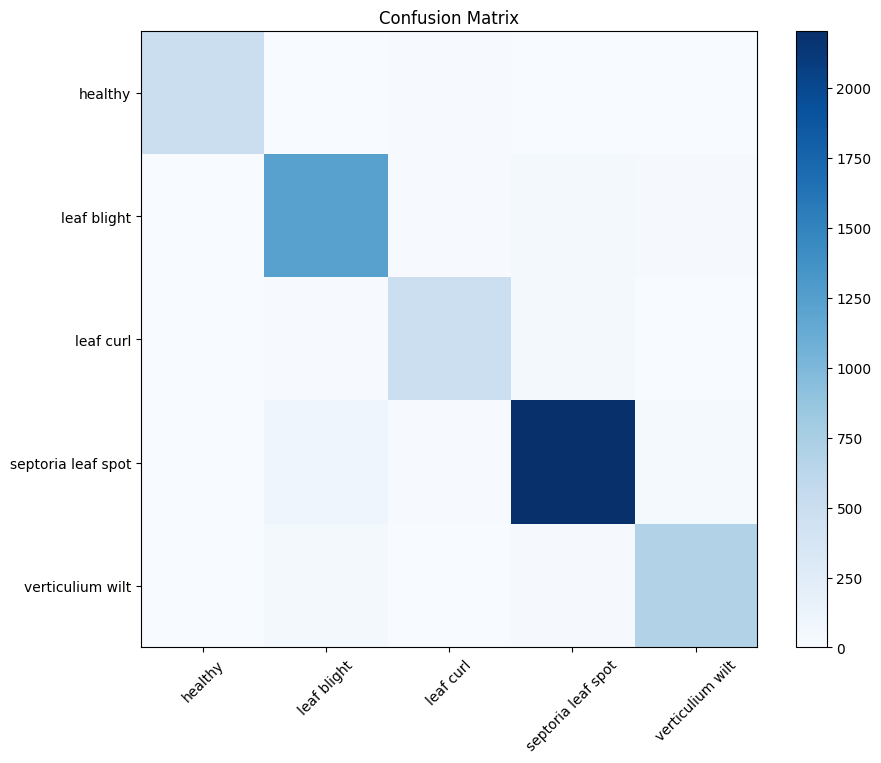

In [ ]:
# ## 9. Execute Training
# ### Option 1: Test single crop (recommended first)
train_crop('Tomato')  # ✅ Start with Tomato

# ### Option 2: Train all crops (uncomment when ready)
# train_all_crops()


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weight

Epoch 1:   0%|          | 0/304 [00:00<?, ?it/s]

[Epoch 1] Loss: 0.6286


Epoch 2:   0%|          | 0/304 [00:00<?, ?it/s]

[Epoch 2] Loss: 0.4102


Epoch 3:   0%|          | 0/304 [00:00<?, ?it/s]

[Epoch 3] Loss: 0.3547


Epoch 4:   0%|          | 0/304 [00:00<?, ?it/s]

[Epoch 4] Loss: 0.3125


Epoch 5:   0%|          | 0/304 [00:00<?, ?it/s]

[Epoch 5] Loss: 0.2801
✅ Model saved to: /content/drive/MyDrive/trained_models/Maize_epoch4.pth


Epoch 6:   0%|          | 0/304 [00:00<?, ?it/s]

[Epoch 6] Loss: 0.2609


Epoch 7:   0%|          | 0/304 [00:00<?, ?it/s]

[Epoch 7] Loss: 0.2439


Epoch 8:   0%|          | 0/304 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79f0cbf56c00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x79f0cbf56c00>
^^^^Traceback (most recent call last):
^^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^^
      File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    self._shutdown_workers()assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

        if w.is_alive():  
       ^^ ^ ^ ^  ^^^^^^^^^^^^^^^^^^
 

[Epoch 8] Loss: 0.2290


Epoch 9:   0%|          | 0/304 [00:00<?, ?it/s]

[Epoch 9] Loss: 0.2214


Epoch 10:   0%|          | 0/304 [00:00<?, ?it/s]

[Epoch 10] Loss: 0.2110
✅ Model saved to: /content/drive/MyDrive/trained_models/Maize_epoch9.pth


Epoch 11:   0%|          | 0/304 [00:00<?, ?it/s]

[Epoch 11] Loss: 0.2028


Epoch 12:   0%|          | 0/304 [00:00<?, ?it/s]

[Epoch 12] Loss: 0.1973


Epoch 13:   0%|          | 0/304 [00:00<?, ?it/s]

[Epoch 13] Loss: 0.1888


Epoch 14:   0%|          | 0/304 [00:00<?, ?it/s]

[Epoch 14] Loss: 0.1820


Epoch 15:   0%|          | 0/304 [00:00<?, ?it/s]

[Epoch 15] Loss: 0.1837
✅ Model saved to: /content/drive/MyDrive/trained_models/Maize_epoch14.pth


Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

               precision    recall  f1-score   support

fall armyworm       0.96      0.94      0.95       284
   grasshoper       0.97      0.96      0.97       411
      healthy       0.79      0.90      0.84       211
  leaf beetle       0.96      0.98      0.97       950
  leaf blight       0.76      0.94      0.84      1004
    leaf spot       0.92      0.71      0.80      1261
 streak virus       0.93      0.94      0.94      1004

     accuracy                           0.89      5125
    macro avg       0.90      0.91      0.90      5125
 weighted avg       0.90      0.89      0.89      5125



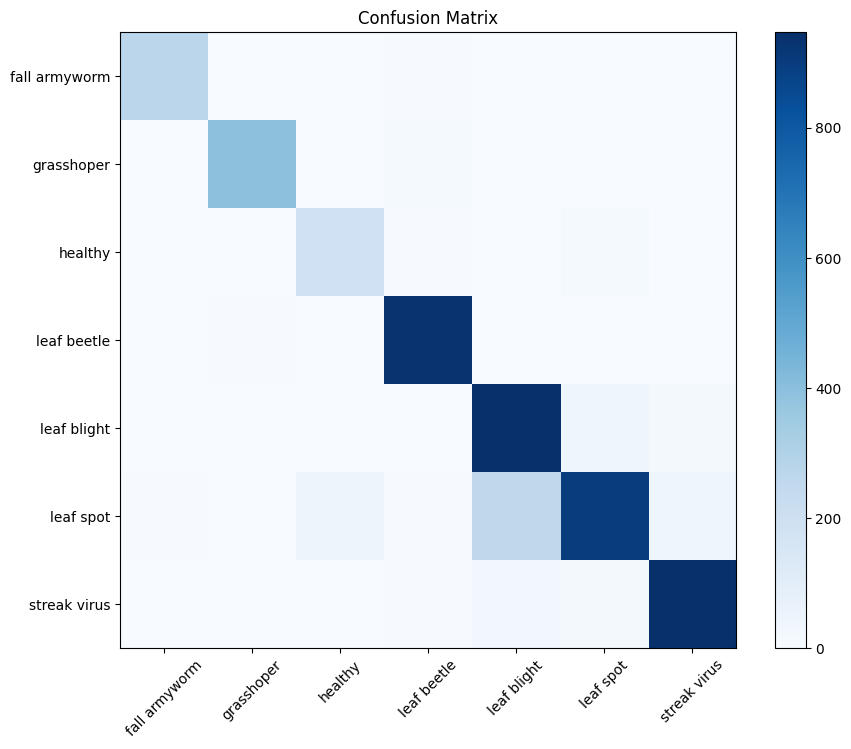

In [ ]:
train_crop('Maize')

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weight

Epoch 1:   0%|          | 0/296 [00:00<?, ?it/s]

[Epoch 1] Loss: 0.3112


Epoch 2:   0%|          | 0/296 [00:00<?, ?it/s]

[Epoch 2] Loss: 0.1682


Epoch 3:   0%|          | 0/296 [00:00<?, ?it/s]

[Epoch 3] Loss: 0.1441


Epoch 4:   0%|          | 0/296 [00:00<?, ?it/s]

[Epoch 4] Loss: 0.1175


Epoch 5:   0%|          | 0/296 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79f0cbf56c00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79f0cbf56c00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

[Epoch 5] Loss: 0.1133
✅ Model saved to: /content/drive/MyDrive/trained_models/Cashew_epoch4.pth


Epoch 6:   0%|          | 0/296 [00:00<?, ?it/s]

[Epoch 6] Loss: 0.1046


Epoch 7:   0%|          | 0/296 [00:00<?, ?it/s]

[Epoch 7] Loss: 0.0919


Epoch 8:   0%|          | 0/296 [00:00<?, ?it/s]

[Epoch 8] Loss: 0.0853


Epoch 9:   0%|          | 0/296 [00:00<?, ?it/s]

[Epoch 9] Loss: 0.0890


Epoch 10:   0%|          | 0/296 [00:00<?, ?it/s]

[Epoch 10] Loss: 0.0798
✅ Model saved to: /content/drive/MyDrive/trained_models/Cashew_epoch9.pth


Epoch 11:   0%|          | 0/296 [00:00<?, ?it/s]

[Epoch 11] Loss: 0.0833


Epoch 12:   0%|          | 0/296 [00:00<?, ?it/s]

[Epoch 12] Loss: 0.0712


Epoch 13:   0%|          | 0/296 [00:00<?, ?it/s]

[Epoch 13] Loss: 0.0703


Epoch 14:   0%|          | 0/296 [00:00<?, ?it/s]

[Epoch 14] Loss: 0.0664


Epoch 15:   0%|          | 0/296 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79f0cbf56c00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79f0cbf56c00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

[Epoch 15] Loss: 0.0642
✅ Model saved to: /content/drive/MyDrive/trained_models/Cashew_epoch14.pth


Evaluating:   0%|          | 0/108 [00:00<?, ?it/s]

              precision    recall  f1-score   support

 anthracnose       0.95      0.89      0.92      1838
     gumosis       1.00      1.00      1.00       425
     healthy       0.92      0.99      0.96      1336
  leaf miner       0.94      0.94      0.94      1487
    red rust       0.98      0.99      0.99      1815

    accuracy                           0.95      6901
   macro avg       0.96      0.96      0.96      6901
weighted avg       0.95      0.95      0.95      6901



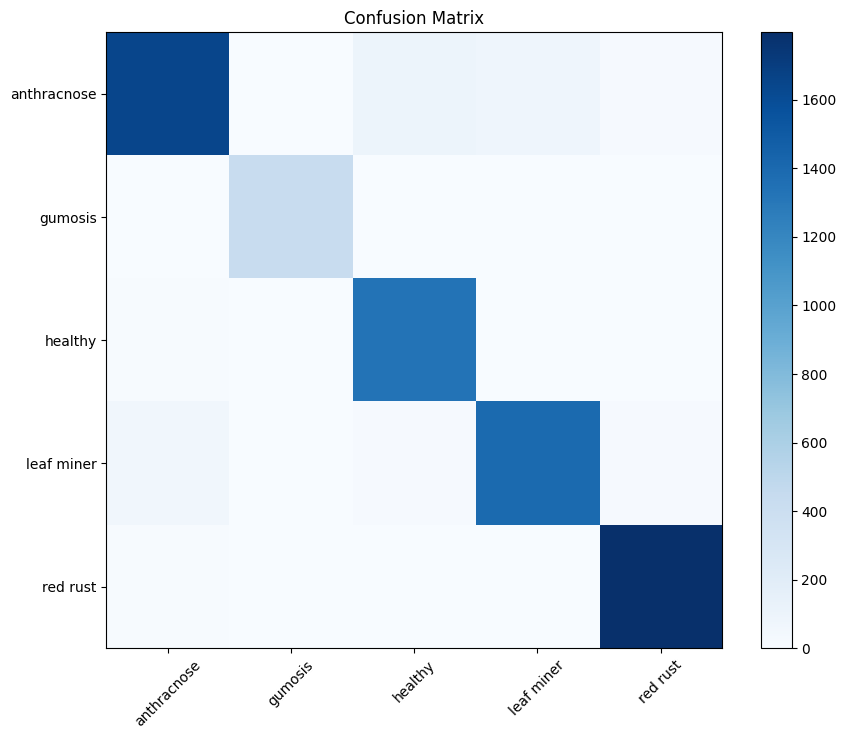

In [ ]:
train_crop('Cashew')

Epoch 1:   0%|          | 0/116 [00:00<?, ?it/s]

[Epoch 1] Loss: 0.2959


Epoch 2:   0%|          | 0/116 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d10cc0ccf40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d10cc0ccf40>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7d10cc0ccf40>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in 

[Epoch 2] Loss: 0.0719


Epoch 3:   0%|          | 0/116 [00:00<?, ?it/s]

[Epoch 3] Loss: 0.0525


Epoch 4:   0%|          | 0/116 [00:00<?, ?it/s]

[Epoch 4] Loss: 0.0353


Epoch 5:   0%|          | 0/116 [00:00<?, ?it/s]

[Epoch 5] Loss: 0.0310
✅ Model saved to: /content/drive/MyDrive/trained_models/Bean_epoch4.pth


Epoch 6:   0%|          | 0/116 [00:00<?, ?it/s]

[Epoch 6] Loss: 0.0387


Epoch 7:   0%|          | 0/116 [00:00<?, ?it/s]

[Epoch 7] Loss: 0.0247


Epoch 8:   0%|          | 0/116 [00:00<?, ?it/s]

[Epoch 8] Loss: 0.0368


Epoch 9:   0%|          | 0/116 [00:00<?, ?it/s]

[Epoch 9] Loss: 0.0249


Epoch 10:   0%|          | 0/116 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d10cc0ccf40>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7d10cc0ccf40>    
self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        if w.is_alive():self._shutdown_workers()

   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
      if w.is_alive(): 
      ^^^    ^^^^^^^^^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^^^^
  File "/usr/lib/pytho

[Epoch 10] Loss: 0.0252
✅ Model saved to: /content/drive/MyDrive/trained_models/Bean_epoch9.pth


Epoch 11:   0%|          | 0/116 [00:00<?, ?it/s]

[Epoch 11] Loss: 0.0249


Epoch 12:   0%|          | 0/116 [00:00<?, ?it/s]

[Epoch 12] Loss: 0.0194


Epoch 13:   0%|          | 0/116 [00:00<?, ?it/s]

[Epoch 13] Loss: 0.0224


Epoch 14:   0%|          | 0/116 [00:00<?, ?it/s]

[Epoch 14] Loss: 0.0303


Epoch 15:   0%|          | 0/116 [00:00<?, ?it/s]

[Epoch 15] Loss: 0.0213
✅ Model saved to: /content/drive/MyDrive/trained_models/Bean_epoch14.pth


Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

                      precision    recall  f1-score   support

   angular leaf spot       1.00      1.00      1.00        29
         anthracnose       1.00      1.00      1.00       120
cercospora leaf spot       1.00      1.00      1.00        17
     fungi pathogens       1.00      1.00      1.00        27
         halo blight       1.00      1.00      1.00        25
             healthy       1.00      0.99      0.99       238
potassium deficiency       1.00      1.00      1.00         8
                rust       0.98      1.00      0.99       120

            accuracy                           0.99       584
           macro avg       1.00      1.00      1.00       584
        weighted avg       0.99      0.99      0.99       584



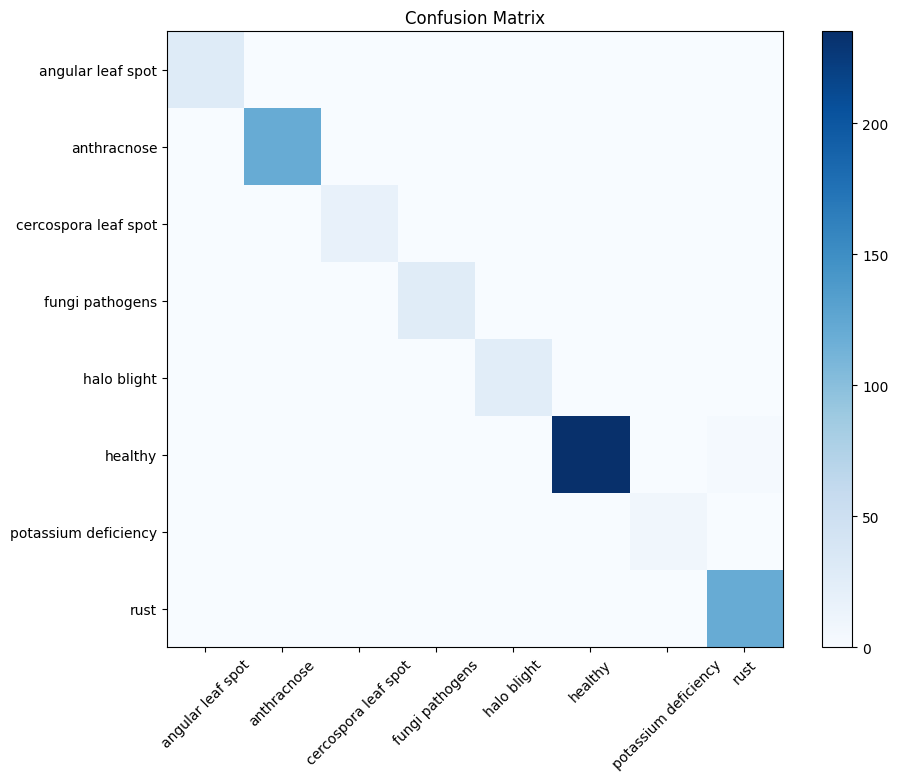

In [ ]:
train_crop('Bean')

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weight

Epoch 1:   0%|          | 0/147 [00:00<?, ?it/s]

[Epoch 1] Loss: 0.4036


Epoch 2:   0%|          | 0/147 [00:00<?, ?it/s]

[Epoch 2] Loss: 0.1666


Epoch 3:   0%|          | 0/147 [00:00<?, ?it/s]

[Epoch 3] Loss: 0.1421


Epoch 4:   0%|          | 0/147 [00:00<?, ?it/s]

[Epoch 4] Loss: 0.1217


Epoch 5:   0%|          | 0/147 [00:00<?, ?it/s]

[Epoch 5] Loss: 0.1102
✅ Model saved to: /content/drive/MyDrive/trained_models/Potato_epoch4.pth


Epoch 6:   0%|          | 0/147 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79e9104728e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79e9104728e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

[Epoch 6] Loss: 0.1105


Epoch 7:   0%|          | 0/147 [00:00<?, ?it/s]

[Epoch 7] Loss: 0.0913


Epoch 8:   0%|          | 0/147 [00:00<?, ?it/s]

[Epoch 8] Loss: 0.0968


Epoch 9:   0%|          | 0/147 [00:00<?, ?it/s]

[Epoch 9] Loss: 0.0991


Epoch 10:   0%|          | 0/147 [00:00<?, ?it/s]

[Epoch 10] Loss: 0.0839
✅ Model saved to: /content/drive/MyDrive/trained_models/Potato_epoch9.pth


Epoch 11:   0%|          | 0/147 [00:00<?, ?it/s]

[Epoch 11] Loss: 0.0736


Epoch 12:   0%|          | 0/147 [00:00<?, ?it/s]

[Epoch 12] Loss: 0.0793


Epoch 13:   0%|          | 0/147 [00:00<?, ?it/s]

[Epoch 13] Loss: 0.0794


Epoch 14:   0%|          | 0/147 [00:00<?, ?it/s]

[Epoch 14] Loss: 0.0819


Epoch 15:   0%|          | 0/147 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79e9104728e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x79e9104728e0>^
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    ^if w.is_alive():
 ^ ^ 
   File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
      assert self._parent_pid == os.getpid(), 'can only test a child process' 
^ ^^^^ ^ ^ ^ ^ ^ ^ ^
     File "/usr

[Epoch 15] Loss: 0.0718
✅ Model saved to: /content/drive/MyDrive/trained_models/Potato_epoch14.pth


Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

                            precision    recall  f1-score   support

blackspot bruising disease       0.85      0.97      0.91        77
         brown rot disease       0.87      0.93      0.90        14
           dry rot disease       0.96      0.92      0.94       130
              early blight       1.00      1.00      1.00       158
                   healthy       0.89      0.99      0.93        87
               late blight       1.00      0.93      0.96       158
          soft rot disease       0.92      0.82      0.87        56

                  accuracy                           0.95       680
                 macro avg       0.93      0.94      0.93       680
              weighted avg       0.95      0.95      0.95       680



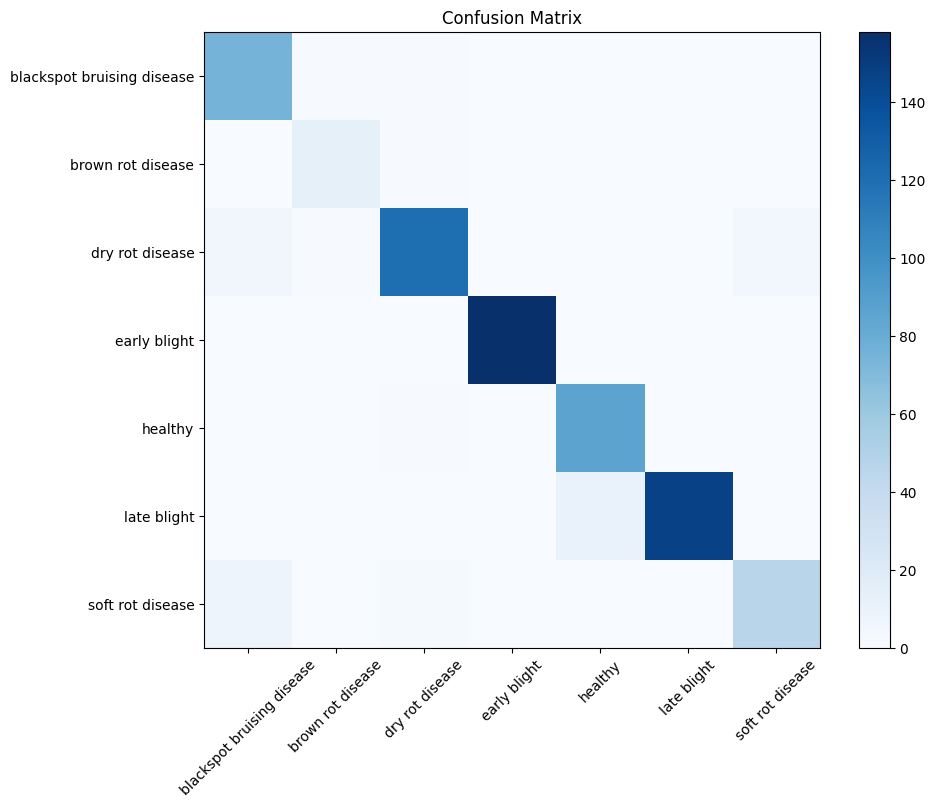

In [ ]:
train_crop('Potato')

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weight

Epoch 1:   0%|          | 0/316 [00:00<?, ?it/s]

[Epoch 1] Loss: 0.4223


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 2:   0%|          | 0/316 [00:00<?, ?it/s]

[Epoch 2] Loss: 0.2542


Epoch 3:   0%|          | 0/316 [00:00<?, ?it/s]

[Epoch 3] Loss: 0.2065


Epoch 4:   0%|          | 0/316 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d2228647880>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7d2228647880> 
 Traceback (most recent call last):
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
       self._shutdown_workers()^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^    ^if w.is_alive():^
^ ^ ^ ^ ^ ^ ^ ^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^^Exception ignored in: ^<funct

[Epoch 4] Loss: 0.1750


Epoch 5:   0%|          | 0/316 [00:00<?, ?it/s]

wandb: WARNING Saving files without folders. If you want to preserve subdirectories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


[Epoch 5] Loss: 0.1629
✅ Model saved to: /content/drive/MyDrive/trained_models/Cassava_epoch5.pth


Epoch 6:   0%|          | 0/316 [00:00<?, ?it/s]

[Epoch 6] Loss: 0.1497


Epoch 7:   0%|          | 0/316 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d2228647880>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d2228647880>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

    self._shutdown_workers()Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    if w.is_alive(): 
      
 self._shutdown_workers()    File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
     ^if w.is_alive():^^
 ^  ^ ^^ ^ ^ ^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'^
^  ^ ^^  ^    ^ Exception ignore

[Epoch 7] Loss: 0.1416


Epoch 8:   0%|          | 0/316 [00:00<?, ?it/s]

[Epoch 8] Loss: 0.1280


Epoch 9:   0%|          | 0/316 [00:00<?, ?it/s]

[Epoch 9] Loss: 0.1268


Epoch 10:   0%|          | 0/316 [00:00<?, ?it/s]

[Epoch 10] Loss: 0.1130
✅ Model saved to: /content/drive/MyDrive/trained_models/Cassava_epoch10.pth


Epoch 11:   0%|          | 0/316 [00:00<?, ?it/s]

[Epoch 11] Loss: 0.1123


Epoch 12:   0%|          | 0/316 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d2228647880>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d2228647880>assert self._parent_pid == os.getpid(), 'can only test a child process'
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

     if w.is_alive():    
            ^ ^^Exception ignored in: 

[Epoch 12] Loss: 0.1027


Epoch 13:   0%|          | 0/316 [00:00<?, ?it/s]

[Epoch 13] Loss: 0.1013


Epoch 14:   0%|          | 0/316 [00:00<?, ?it/s]

[Epoch 14] Loss: 0.0903


Epoch 15:   0%|          | 0/316 [00:00<?, ?it/s]

[Epoch 15] Loss: 0.0939
✅ Model saved to: /content/drive/MyDrive/trained_models/Cassava_epoch15.pth


Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d2228647880>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d2228647880>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

                  precision    recall  f1-score   support

bacterial blight       0.95      0.96      0.96      2623
      brown spot       0.97      0.93      0.95      1483
      green mite       0.92      0.95      0.93      1020
         healthy       0.98      0.96      0.97      1184
          mosaic       0.96      0.96      0.96      1200

        accuracy                           0.95      7510
       macro avg       0.95      0.95      0.95      7510
    weighted avg       0.95      0.95      0.95      7510



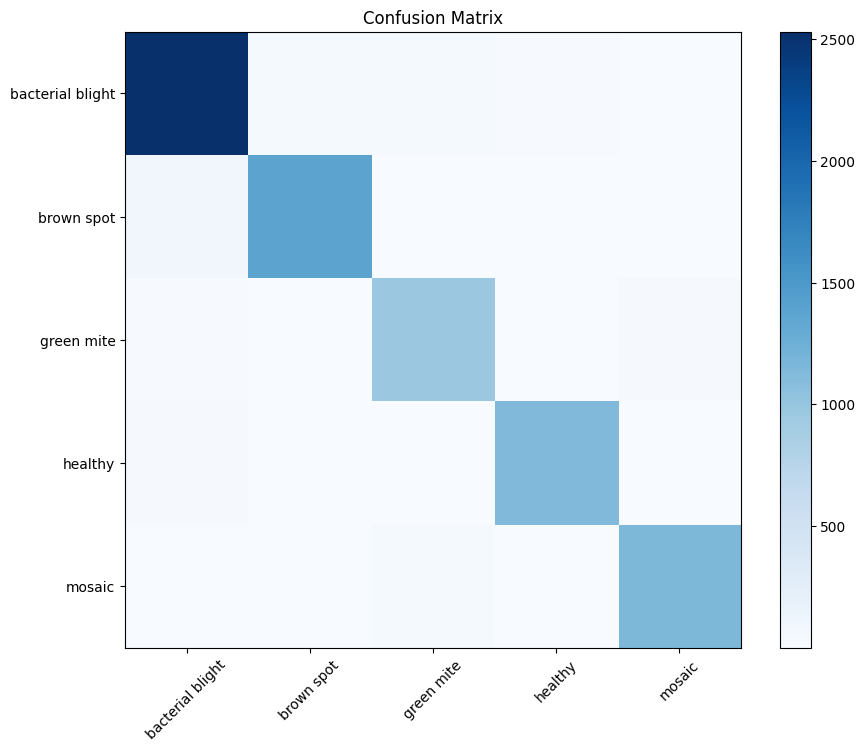

In [ ]:
train_crop('Cassava')

In [ ]:
wandb.finish()

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_loss,█▄▃▃▃▂▂▂▂▁▁▁▁▁▁
epoch,15
train_loss,0.09386
